In [ ]:
# Load Libraries 
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from sklearn.metrics import mean_squared_error
from tensorflow.python.keras.layers import Lambda
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from sklearn.preprocessing import MinMaxScaler
import h5py
import math
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from google.colab import files
from numpy import savetxt
from keras.utils.vis_utils import plot_model
from keras.models import load_model
np.random.seed(20)   
tf.random.set_seed(20)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Function: Create Data History
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)-1):
		end_ix = i + n_steps
		if end_ix > len(data)-1:
			break
		x1, y1 = data[i:end_ix, :-1], data[end_ix, -1]  
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)

**# Transfer Learning: p5271 #**

In [ ]:
# Load the data
data1 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271_Data.mat')
data2 = loadmat('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/Data/p5271MechData.mat')
a_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2), 'freqQAmpI_filt':data1['freqQAmpI_filt'].ravel()})
w_t = pd.DataFrame({'Time':data1['LocalAcTime'].ravel().round(2),'C_filt':data1['C_filt'].ravel()})
m_t = pd.DataFrame({'Time':data1['Time'].ravel().round(2), 'SS':data1['SS'].ravel()}) 
s_t = pd.DataFrame({'Time':data2['Time'].ravel().round(2), 'V':data2['V'].ravel(), 'V_filt':data2['V_filt'].ravel()})
df = a_t.merge(w_t, on='Time')
df = df.merge(m_t, on='Time')
df = df.merge(s_t, on='Time')
df = df[['freqQAmpI_filt', 'C_filt','Time','V_filt','SS']]
df_SS = df[['freqQAmpI_filt','C_filt','SS']] 
df_V = df[['freqQAmpI_filt','C_filt','V_filt']] 
df_A = df[['freqQAmpI_filt','C_filt','freqQAmpI_filt']]
df_WV = df[['freqQAmpI_filt','C_filt','C_filt']]
xdf = df[['freqQAmpI_filt', 'C_filt']]
ydf = df[['SS','V_filt']]
print("Input Data:\n", xdf)
print("Target Data:\n",ydf)

Input Data:
        freqQAmpI_filt       C_filt
0        86444.183014  5713.739611
1        86444.358094  5713.748279
2        86442.647757  5713.750421
3        86419.380962  5713.758606
4        86414.552286  5713.772870
...               ...          ...
75994    81488.107323  5720.364457
75995    81375.846782  5720.365210
75996    81263.154871  5720.384980
75997    81137.502620  5720.393775
75998    80982.695515  5720.397332

[75999 rows x 2 columns]
Target Data:
              SS     V_filt
0      5.893849  10.577261
1      5.893360  10.282278
2      5.893242  10.050505
3      5.893039   9.903014
4      5.892528   9.945154
...         ...        ...
75994  5.850977   0.674248
75995  5.851531   0.653177
75996  5.852108   0.863880
75997  5.852526   0.716388
75998  5.852725   0.863880

[75999 rows x 2 columns]


In [ ]:
# Preprocessing (SS)
arr = df_SS.to_numpy()
n_steps = 300
xdf, ydf_SS = create_timesteps(arr, n_steps)

# Preprocessing (V)
arr = df_V.to_numpy()
n_steps = 300
xdf, ydf_V = create_timesteps(arr, n_steps)

# Preprocessing (A)
arr = df_A.to_numpy()
n_steps = 300
xdf, ydf_A = create_timesteps(arr, n_steps)

# Preprocessing (WV)
arr = df_WV.to_numpy()
n_steps = 300
xdf, ydf_WV = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape (SS), Y = ', np.shape(ydf_SS))
print('Target shape (V), Y = ', np.shape(ydf_V))

# Reshape
in_dim = xdf.shape[1]*xdf.shape[2]
xdf = xdf.reshape((xdf.shape[0], in_dim))
print('After reshaping, X = ', np.shape(xdf))

Features shape, X =  (75699, 300, 2)
Target shape (SS), Y =  (75699,)
Target shape (V), Y =  (75699,)
After reshaping, X =  (75699, 600)


In [ ]:
# Split into train-val-test (SS)
x_train, x_test, y_train_SS, y_test_SS = train_test_split(xdf, ydf_SS, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_SS, Y_val_SS = train_test_split(x_train, y_train_SS, test_size=0.125, shuffle=False)

# Split into train-val-test (V)
x_train, x_test, y_train_V, y_test_V = train_test_split(xdf, ydf_V, test_size=0.2, shuffle=False)
X_train, X_val, Y_train_V, Y_val_V = train_test_split(x_train, y_train_V, test_size=0.125, shuffle=False)

# Select Training Data Percentage 
X_train = X_train[30399:53199]
Y_train_SS = Y_train_SS[30399:53199]
Y_train_V = Y_train_V[30399:53199]

# Normalize the input
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_val = pd.DataFrame(scaler.transform(X_val))
x_test = pd.DataFrame(scaler.transform(x_test))

print("Training samples:", np.shape(X_train)[0])
print("Validation samples:", np.shape(X_val)[0])
print("Testing samples:", np.shape(x_test)[0])

Training samples: 22590
Validation samples: 7570
Testing samples: 15140


In [ ]:
# Normalize the output: SS
scaler_ss = MinMaxScaler()
Y_train_SS = pd.DataFrame(scaler_ss.fit_transform(Y_train_SS.reshape(-1, 1)))
Y_val_SS = pd.DataFrame(scaler_ss.transform(Y_val_SS.reshape(-1, 1)))
y_test_SS = pd.DataFrame(scaler_ss.transform(y_test_SS.reshape(-1, 1)))

In [ ]:
# Normalize the output: V
scaler_v = MinMaxScaler()
Y_train_V = pd.DataFrame(scaler_v.fit_transform(Y_train_V.reshape(-1, 1)))
Y_val_V = pd.DataFrame(scaler_v.transform(Y_val_V.reshape(-1, 1)))
y_test_V = pd.DataFrame(scaler_v.transform(y_test_V.reshape(-1, 1)))

Train on 22590 samples, validate on 7570 samples
Epoch 1/100
22464/22590 [============================>.] - ETA: 0s - loss: 0.0168 - dense_5_loss: 0.0115 - dense_6_loss: 0.0053
Epoch 1: val_loss improved from inf to 0.00729, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


22590/22590 [==============================] - 3s 148us/sample - loss: 0.0168 - dense_5_loss: 0.0115 - dense_6_loss: 0.0053 - val_loss: 0.0073 - val_dense_5_loss: 0.0061 - val_dense_6_loss: 0.0012
Epoch 2/100
22368/22590 [============================>.] - ETA: 0s - loss: 0.0058 - dense_5_loss: 0.0044 - dense_6_loss: 0.0013
Epoch 2: val_loss improved from 0.00729 to 0.00719, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


22590/22590 [==============================] - 2s 97us/sample - loss: 0.0058 - dense_5_loss: 0.0044 - dense_6_loss: 0.0013 - val_loss: 0.0072 - val_dense_5_loss: 0.0059 - val_dense_6_loss: 0.0013
Epoch 3/100
21984/22590 [============================>.] - ETA: 0s - loss: 0.0048 - dense_5_loss: 0.0036 - dense_6_loss: 0.0012
Epoch 3: val_loss improved from 0.00719 to 0.00648, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


22590/22590 [==============================] - 2s 98us/sample - loss: 0.0048 - dense_5_loss: 0.0036 - dense_6_loss: 0.0012 - val_loss: 0.0065 - val_dense_5_loss: 0.0057 - val_dense_6_loss: 7.8405e-04
Epoch 4/100
21760/22590 [===========================>..] - ETA: 0s - loss: 0.0043 - dense_5_loss: 0.0032 - dense_6_loss: 0.0010
Epoch 4: val_loss improved from 0.00648 to 0.00526, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


22590/22590 [==============================] - 2s 98us/sample - loss: 0.0043 - dense_5_loss: 0.0032 - dense_6_loss: 0.0010 - val_loss: 0.0053 - val_dense_5_loss: 0.0046 - val_dense_6_loss: 6.3886e-04
Epoch 5/100
21824/22590 [===========================>..] - ETA: 0s - loss: 0.0041 - dense_5_loss: 0.0031 - dense_6_loss: 9.7903e-04
Epoch 5: val_loss improved from 0.00526 to 0.00493, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


22590/22590 [==============================] - 2s 98us/sample - loss: 0.0041 - dense_5_loss: 0.0031 - dense_6_loss: 9.7761e-04 - val_loss: 0.0049 - val_dense_5_loss: 0.0042 - val_dense_6_loss: 7.3110e-04
Epoch 6/100
21696/22590 [===========================>..] - ETA: 0s - loss: 0.0038 - dense_5_loss: 0.0029 - dense_6_loss: 8.8631e-04
Epoch 6: val_loss improved from 0.00493 to 0.00467, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


22590/22590 [==============================] - 2s 109us/sample - loss: 0.0039 - dense_5_loss: 0.0030 - dense_6_loss: 8.9370e-04 - val_loss: 0.0047 - val_dense_5_loss: 0.0041 - val_dense_6_loss: 5.7547e-04
Epoch 7/100
21600/22590 [===========================>..] - ETA: 0s - loss: 0.0038 - dense_5_loss: 0.0029 - dense_6_loss: 9.6227e-04
Epoch 7: val_loss did not improve from 0.00467
22590/22590 [==============================] - 1s 54us/sample - loss: 0.0038 - dense_5_loss: 0.0028 - dense_6_loss: 9.5904e-04 - val_loss: 0.0047 - val_dense_5_loss: 0.0041 - val_dense_6_loss: 5.8324e-04
Epoch 8/100
21760/22590 [===========================>..] - ETA: 0s - loss: 0.0035 - dense_5_loss: 0.0027 - dense_6_loss: 8.2717e-04
Epoch 8: val_loss did not improve from 0.00467
22590/22590 [==============================] - 1s 54us/sample - loss: 0.0035 - dense_5_loss: 0.0026 - dense_6_loss: 8.2521e-04 - val_loss: 0.0054 - val_dense_5_loss: 0.0047 - val_dense_6_loss: 7.1901e-04
Epoch 9/100
22560/22590 [====

22590/22590 [==============================] - 2s 101us/sample - loss: 0.0036 - dense_5_loss: 0.0027 - dense_6_loss: 8.9272e-04 - val_loss: 0.0045 - val_dense_5_loss: 0.0039 - val_dense_6_loss: 5.9239e-04
Epoch 10/100
21760/22590 [===========================>..] - ETA: 0s - loss: 0.0032 - dense_5_loss: 0.0025 - dense_6_loss: 7.7790e-04
Epoch 10: val_loss improved from 0.00450 to 0.00412, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


22590/22590 [==============================] - 2s 96us/sample - loss: 0.0032 - dense_5_loss: 0.0024 - dense_6_loss: 7.6619e-04 - val_loss: 0.0041 - val_dense_5_loss: 0.0036 - val_dense_6_loss: 4.9874e-04
Epoch 11/100
21536/22590 [===========================>..] - ETA: 0s - loss: 0.0032 - dense_5_loss: 0.0024 - dense_6_loss: 8.0894e-04
Epoch 11: val_loss did not improve from 0.00412
22590/22590 [==============================] - 1s 57us/sample - loss: 0.0032 - dense_5_loss: 0.0024 - dense_6_loss: 8.1517e-04 - val_loss: 0.0047 - val_dense_5_loss: 0.0041 - val_dense_6_loss: 5.6499e-04
Epoch 12/100
22496/22590 [============================>.] - ETA: 0s - loss: 0.0032 - dense_5_loss: 0.0023 - dense_6_loss: 8.1206e-04
Epoch 12: val_loss did not improve from 0.00412
22590/22590 [==============================] - 1s 54us/sample - loss: 0.0032 - dense_5_loss: 0.0023 - dense_6_loss: 8.1186e-04 - val_loss: 0.0049 - val_dense_5_loss: 0.0041 - val_dense_6_loss: 7.8157e-04
Epoch 13/100
21952/22590 [

22590/22590 [==============================] - 2s 97us/sample - loss: 0.0031 - dense_5_loss: 0.0023 - dense_6_loss: 8.2378e-04 - val_loss: 0.0041 - val_dense_5_loss: 0.0036 - val_dense_6_loss: 4.6471e-04
Epoch 14/100
22368/22590 [============================>.] - ETA: 0s - loss: 0.0030 - dense_5_loss: 0.0023 - dense_6_loss: 7.5999e-04
Epoch 14: val_loss did not improve from 0.00409
22590/22590 [==============================] - 1s 55us/sample - loss: 0.0030 - dense_5_loss: 0.0023 - dense_6_loss: 7.5724e-04 - val_loss: 0.0042 - val_dense_5_loss: 0.0037 - val_dense_6_loss: 5.6142e-04
Epoch 15/100
22560/22590 [============================>.] - ETA: 0s - loss: 0.0030 - dense_5_loss: 0.0022 - dense_6_loss: 7.8171e-04
Epoch 15: val_loss did not improve from 0.00409
22590/22590 [==============================] - 1s 57us/sample - loss: 0.0030 - dense_5_loss: 0.0022 - dense_6_loss: 7.8151e-04 - val_loss: 0.0042 - val_dense_5_loss: 0.0036 - val_dense_6_loss: 5.3833e-04
Epoch 16/100
22590/22590 [

22590/22590 [==============================] - 2s 101us/sample - loss: 0.0028 - dense_5_loss: 0.0021 - dense_6_loss: 7.5732e-04 - val_loss: 0.0040 - val_dense_5_loss: 0.0035 - val_dense_6_loss: 4.8412e-04
Epoch 19/100
21536/22590 [===========================>..] - ETA: 0s - loss: 0.0029 - dense_5_loss: 0.0021 - dense_6_loss: 7.5023e-04
Epoch 19: val_loss did not improve from 0.00403
22590/22590 [==============================] - 1s 56us/sample - loss: 0.0028 - dense_5_loss: 0.0021 - dense_6_loss: 7.3697e-04 - val_loss: 0.0047 - val_dense_5_loss: 0.0035 - val_dense_6_loss: 0.0012
Epoch 20/100
21728/22590 [===========================>..] - ETA: 0s - loss: 0.0028 - dense_5_loss: 0.0020 - dense_6_loss: 7.2113e-04
Epoch 20: val_loss improved from 0.00403 to 0.00391, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


22590/22590 [==============================] - 3s 146us/sample - loss: 0.0027 - dense_5_loss: 0.0020 - dense_6_loss: 7.1884e-04 - val_loss: 0.0039 - val_dense_5_loss: 0.0034 - val_dense_6_loss: 5.6592e-04
Epoch 21/100
22464/22590 [============================>.] - ETA: 0s - loss: 0.0027 - dense_5_loss: 0.0019 - dense_6_loss: 7.2289e-04
Epoch 21: val_loss did not improve from 0.00391
22590/22590 [==============================] - 2s 92us/sample - loss: 0.0027 - dense_5_loss: 0.0019 - dense_6_loss: 7.2171e-04 - val_loss: 0.0041 - val_dense_5_loss: 0.0036 - val_dense_6_loss: 5.2379e-04
Epoch 22/100
22560/22590 [============================>.] - ETA: 0s - loss: 0.0027 - dense_5_loss: 0.0019 - dense_6_loss: 7.0660e-04
Epoch 22: val_loss did not improve from 0.00391
22590/22590 [==============================] - 2s 84us/sample - loss: 0.0026 - dense_5_loss: 0.0019 - dense_6_loss: 7.0565e-04 - val_loss: 0.0039 - val_dense_5_loss: 0.0033 - val_dense_6_loss: 6.2314e-04
Epoch 23/100
21792/22590 

22590/22590 [==============================] - 2s 99us/sample - loss: 0.0024 - dense_5_loss: 0.0018 - dense_6_loss: 6.7804e-04 - val_loss: 0.0039 - val_dense_5_loss: 0.0033 - val_dense_6_loss: 4.9664e-04
Epoch 30/100
21696/22590 [===========================>..] - ETA: 0s - loss: 0.0024 - dense_5_loss: 0.0017 - dense_6_loss: 6.5187e-04
Epoch 30: val_loss improved from 0.00385 to 0.00369, saving model to /content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check


22590/22590 [==============================] - 2s 98us/sample - loss: 0.0024 - dense_5_loss: 0.0017 - dense_6_loss: 6.4927e-04 - val_loss: 0.0037 - val_dense_5_loss: 0.0032 - val_dense_6_loss: 4.7592e-04
Epoch 31/100
22272/22590 [============================>.] - ETA: 0s - loss: 0.0024 - dense_5_loss: 0.0017 - dense_6_loss: 6.8981e-04
Epoch 31: val_loss did not improve from 0.00369
22590/22590 [==============================] - 1s 57us/sample - loss: 0.0024 - dense_5_loss: 0.0017 - dense_6_loss: 6.8839e-04 - val_loss: 0.0041 - val_dense_5_loss: 0.0034 - val_dense_6_loss: 7.4565e-04
Epoch 32/100
22432/22590 [============================>.] - ETA: 0s - loss: 0.0024 - dense_5_loss: 0.0017 - dense_6_loss: 6.8485e-04
Epoch 32: val_loss did not improve from 0.00369
22590/22590 [==============================] - 1s 57us/sample - loss: 0.0024 - dense_5_loss: 0.0017 - dense_6_loss: 6.8827e-04 - val_loss: 0.0052 - val_dense_5_loss: 0.0045 - val_dense_6_loss: 6.3976e-04
Epoch 33/100
21760/22590 [

22590/22590 [==============================] - 2s 98us/sample - loss: 0.0022 - dense_5_loss: 0.0016 - dense_6_loss: 6.2917e-04 - val_loss: 0.0036 - val_dense_5_loss: 0.0032 - val_dense_6_loss: 4.5174e-04
Epoch 41/100
22112/22590 [============================>.] - ETA: 0s - loss: 0.0023 - dense_5_loss: 0.0016 - dense_6_loss: 6.3646e-04
Epoch 41: val_loss did not improve from 0.00361
22590/22590 [==============================] - 1s 56us/sample - loss: 0.0023 - dense_5_loss: 0.0016 - dense_6_loss: 6.3486e-04 - val_loss: 0.0040 - val_dense_5_loss: 0.0033 - val_dense_6_loss: 6.9273e-04
Epoch 42/100
22240/22590 [============================>.] - ETA: 0s - loss: 0.0021 - dense_5_loss: 0.0015 - dense_6_loss: 5.9631e-04
Epoch 42: val_loss did not improve from 0.00361
22590/22590 [==============================] - 1s 55us/sample - loss: 0.0021 - dense_5_loss: 0.0015 - dense_6_loss: 5.9165e-04 - val_loss: 0.0039 - val_dense_5_loss: 0.0032 - val_dense_6_loss: 6.6834e-04
Epoch 43/100
22048/22590 [

22590/22590 [==============================] - 3s 113us/sample - loss: 0.0022 - dense_5_loss: 0.0016 - dense_6_loss: 6.5349e-04 - val_loss: 0.0035 - val_dense_5_loss: 0.0030 - val_dense_6_loss: 4.9267e-04
Epoch 44/100
21952/22590 [============================>.] - ETA: 0s - loss: 0.0022 - dense_5_loss: 0.0016 - dense_6_loss: 6.4489e-04
Epoch 44: val_loss did not improve from 0.00354
22590/22590 [==============================] - 1s 57us/sample - loss: 0.0022 - dense_5_loss: 0.0016 - dense_6_loss: 6.3983e-04 - val_loss: 0.0046 - val_dense_5_loss: 0.0039 - val_dense_6_loss: 6.0714e-04
Epoch 45/100
22080/22590 [============================>.] - ETA: 0s - loss: 0.0022 - dense_5_loss: 0.0016 - dense_6_loss: 6.2113e-04
Epoch 45: val_loss did not improve from 0.00354
22590/22590 [==============================] - 1s 55us/sample - loss: 0.0022 - dense_5_loss: 0.0016 - dense_6_loss: 6.2159e-04 - val_loss: 0.0041 - val_dense_5_loss: 0.0030 - val_dense_6_loss: 0.0011
Epoch 46/100
22560/22590 [===

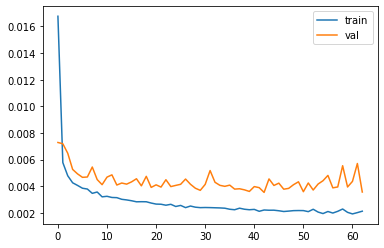

---Training time: 100.17760611 seconds ---


In [ ]:
# Load the pretrained model and re-fit
model = load_model('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/DD_Transfer_model_70_10_20.h5')

model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3))
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=20,verbose=1, mode='auto')  
checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/PINN_Paper_Codes/New_Models/Transfer_Learning_p5271/TL_Data_Driven/Check', monitor='val_loss', verbose=1, save_best_only=True, mode='min')  #Saves best model so far
callbacks_list = [earlystop, checkpoint]
start_time = time.time()
history = model.fit([X_train],[Y_train_SS,Y_train_V], epochs=100, batch_size=32,callbacks=callbacks_list,
                     validation_data=([X_val],[Y_val_SS,Y_val_V]), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 X_train (InputLayer)           [(None, 600)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          76928       ['X_train[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 64)           8256        ['dense[0][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 32)           2080        ['dense_1[0][0]']                
                                                                                              

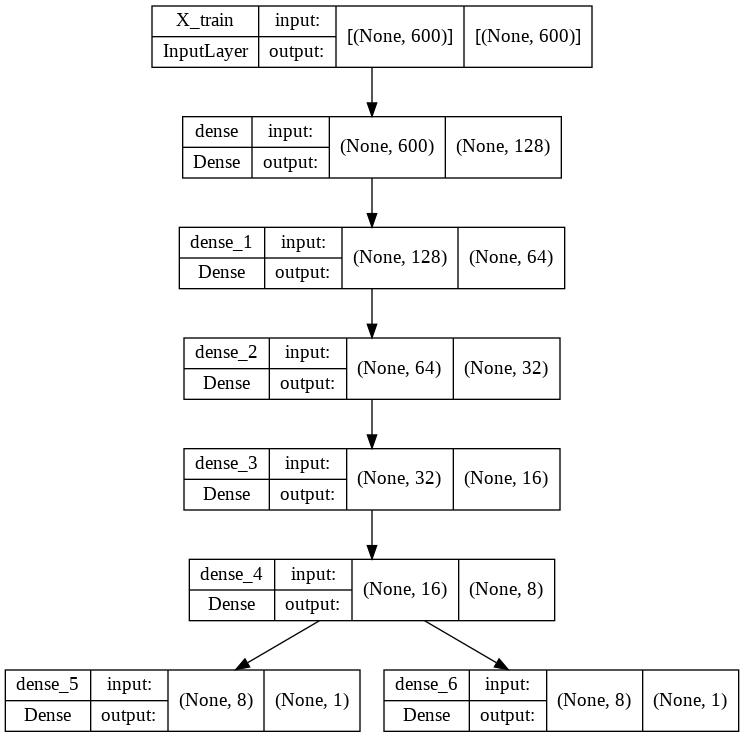

In [ ]:
# Model Summary
print(model.summary())
plot_model(model, show_shapes=True)

In [ ]:
# Model Performance: Training
y_predtrain = model.predict([X_train])
y_predtrain_SS = np.array(y_predtrain)[0,] 
y_predtrain_V =np.array(y_predtrain)[1,] 

train_r2_SS = r2_score(Y_train_SS, y_predtrain_SS) 
train_rmse_SS = np.sqrt(mean_squared_error(Y_train_SS, y_predtrain_SS)) 

train_r2_V = r2_score(Y_train_V,y_predtrain_V ) 
train_rmse_V = np.sqrt(mean_squared_error(Y_train_V, y_predtrain_V )) 

# Model Performance: Validation
y_predval = model.predict([X_val])
y_predval_SS = np.array(y_predval)[0,] 
y_predval_V = np.array(y_predval)[1,] 

val_r2_SS = r2_score(Y_val_SS, y_predval_SS) 
val_rmse_SS = np.sqrt(mean_squared_error(Y_val_SS, y_predval_SS)) 

val_r2_V = r2_score(Y_val_V, y_predval_V) 
val_rmse_V = np.sqrt(mean_squared_error(Y_val_V, y_predval_V)) 

# Model Performance: Testing
y_predtest = model.predict([x_test])
y_predtest_SS =np.array(y_predtest)[0,] 
y_predtest_V = np.array(y_predtest)[1,] 

test_r2_SS = r2_score(y_test_SS,y_predtest_SS) 
test_rmse_SS = np.sqrt(mean_squared_error(y_test_SS, y_predtest_SS)) 

test_r2_V = r2_score(y_test_V,y_predtest_V) 
test_rmse_V = np.sqrt(mean_squared_error(y_test_V, y_predtest_V)) 

# Print R2 Results 
print("R2 scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_r2_SS , train_r2_V))
print("R2 scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_r2_SS , val_r2_V))
print("R2 scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_r2_SS , test_r2_V))

# Print RSME Results
print("RMSE scores: Train (SS) - %0.5f, Train (V) - %0.5f" %(train_rmse_SS , train_rmse_V))
print("RMSE scores: Validation (SS) - %0.5f, Validation (V) - %0.5f" %(val_rmse_SS , val_rmse_V))
print("RMSE scores: Testing (SS) - %0.5f, Testing (V) - %0.5f" %(test_rmse_SS , test_rmse_V))

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


R2 scores: Train (SS) - 0.96107, Train (V) - 0.89277
R2 scores: Validation (SS) - 0.92396, Validation (V) - 0.89738
R2 scores: Testing (SS) - 0.84595, Testing (V) - 0.82139
RMSE scores: Train (SS) - 0.03539, Train (V) - 0.02247
RMSE scores: Validation (SS) - 0.05476, Validation (V) - 0.02383
RMSE scores: Testing (SS) - 0.08448, Testing (V) - 0.03605


In [ ]:
# Inverse scaling: SS 
Y_train_SS = scaler_ss.inverse_transform(Y_train_SS)
Y_val_SS = scaler_ss.inverse_transform(Y_val_SS)
y_test_SS = scaler_ss.inverse_transform(y_test_SS)
y_predtrain_SS = scaler_ss.inverse_transform(y_predtrain_SS)
y_predval_SS = scaler_ss.inverse_transform(y_predval_SS)
y_predtest_SS = scaler_ss.inverse_transform(y_predtest_SS)

In [ ]:
# Inverse scaling: V
Y_train_V = scaler_v.inverse_transform(Y_train_V)
Y_val_V = scaler_v.inverse_transform(Y_val_V)
y_test_V = scaler_v.inverse_transform(y_test_V)
y_predtrain_V = scaler_v.inverse_transform(y_predtrain_V)
y_predval_V = scaler_v.inverse_transform(y_predval_V)
y_predtest_V = scaler_v.inverse_transform(y_predtest_V)

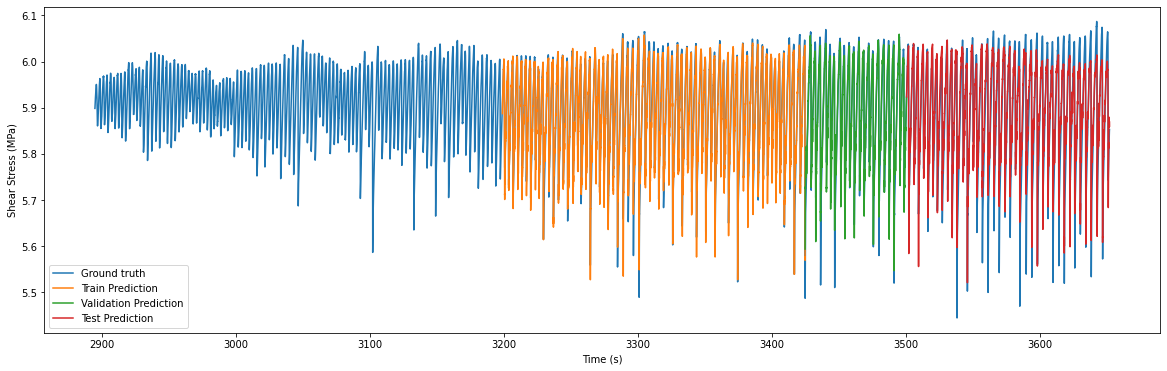

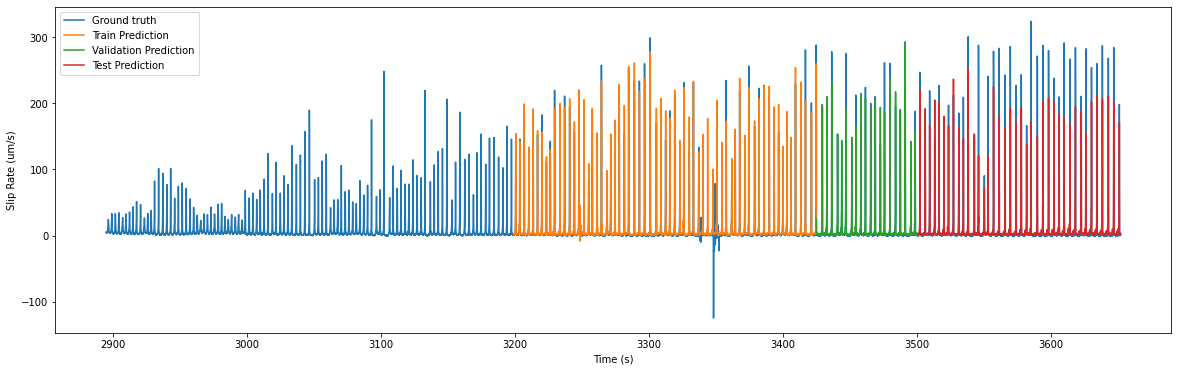

In [ ]:
# Overall plot: SS & V 
ttime = df['Time'][n_steps:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.125, shuffle=False)

traintime = traintime[30399:53199] 

fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf_SS)
plt.plot(traintime, y_predtrain_SS)
plt.plot(valtime, y_predval_SS)
plt.plot(testtime, y_predtest_SS)
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf_V)
plt.plot(traintime, y_predtrain_V)
plt.plot(valtime,  y_predval_V)
plt.plot(testtime, y_predtest_V)
plt.xlabel('Time (s)')
plt.ylabel('Slip Rate (um/s)')
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])

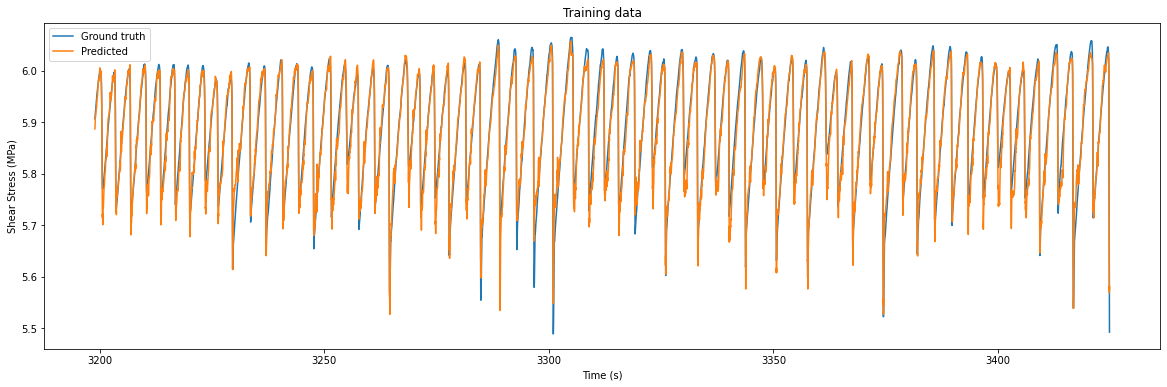

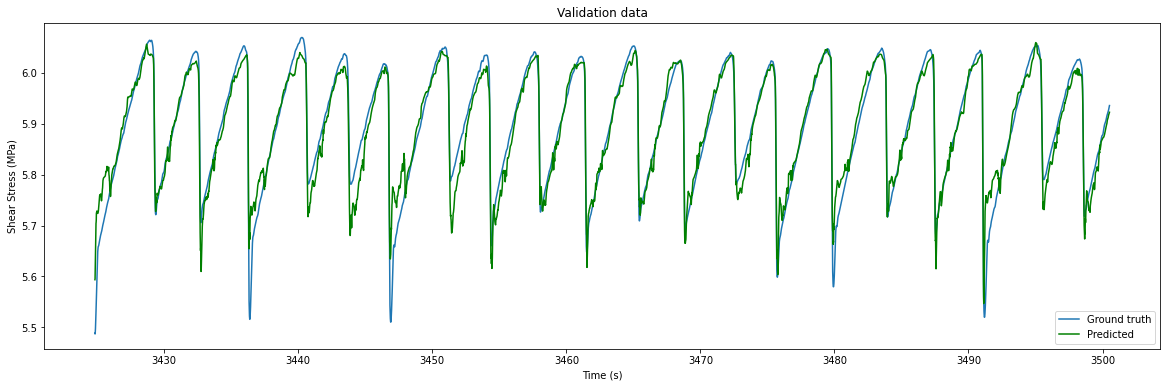

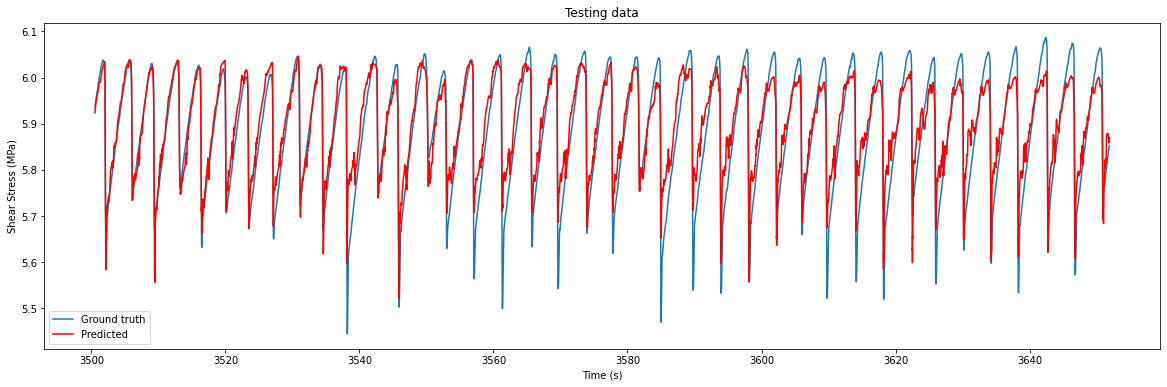

In [ ]:
# # Individual plot: SS

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Shear Stress (MPa)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_SS, y_predtrain_SS, 'Training data', '')
results_plot(2, valtime, Y_val_SS, y_predval_SS, 'Validation data', 'g')
results_plot(3, testtime, y_test_SS, y_predtest_SS, 'Testing data', 'r')

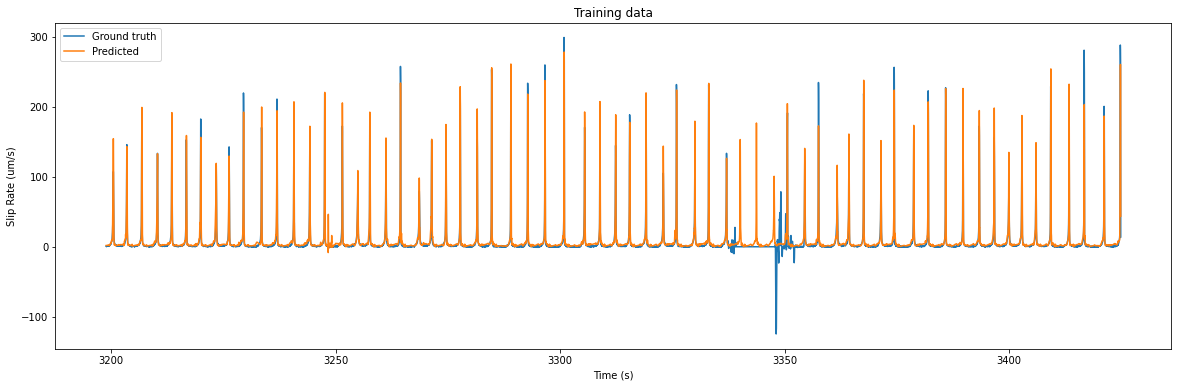

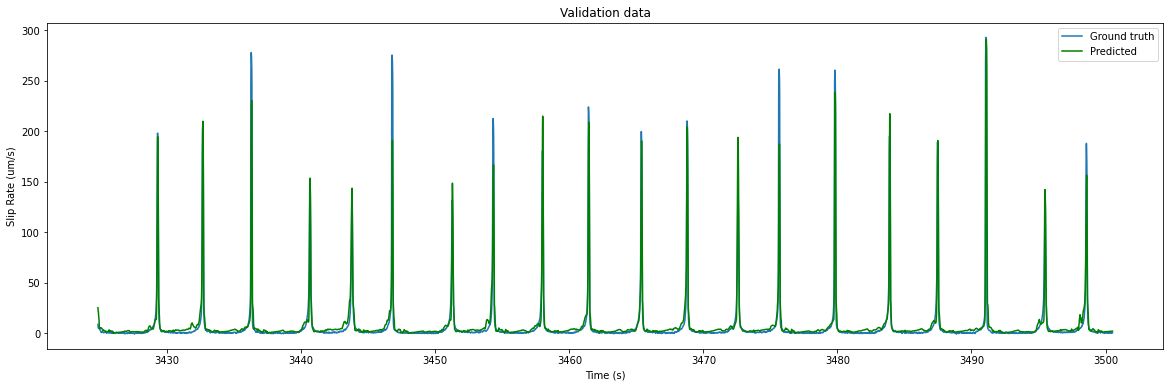

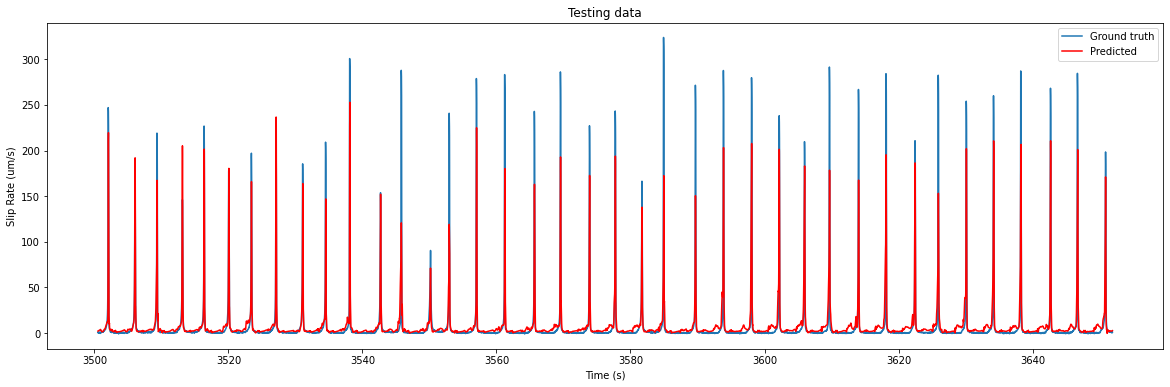

In [ ]:
# # Individual plot: V

def results_plot(fig_no, t, gt, pred, title, col):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(t, gt)
  plt.plot(t, pred, col)
  plt.xlabel('Time (s)')
  plt.ylabel('Slip Rate (um/s)')
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, traintime, Y_train_V, y_predtrain_V, 'Training data', '')
results_plot(2, valtime, Y_val_V, y_predval_V, 'Validation data', 'g')
results_plot(3, testtime, y_test_V, y_predtest_V, 'Testing data', 'r')